##  Importing Required Libraries

We start by importing the essential libraries needed for data manipulation (`pandas`, `numpy`), audio processing (`librosa`), model building (`sklearn`, `xgboost`), and evaluation.


In [ ]:
###  Importing Required Libraries

# os: for interacting with the operating system (file paths, etc.)
# numpy: for numerical operations and array handling
# pandas: for data manipulation and handling CSV files
# librosa: for audio processing and feature extraction
# RandomForestRegressor: regression model from sklearn
# mean_squared_error: evaluation metric for regression performance
# train_test_split: to split dataset into training and testing sets
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


##  Loading Train and Test CSV Files

We load `train.csv` and `test.csv` into pandas DataFrames to prepare them for further processing.
The `train.csv` file contains filenames and labels (grammar scores), while `test.csv` contains filenames only.


In [ ]:
###  Loading the Dataset

# Reading the training data CSV file which contains filenames and their corresponding grammar scores
train_df = pd.read_csv("train.csv")

# Reading the test data CSV file which contains only filenames (labels will be predicted)
test_df = pd.read_csv("test.csv")

# Displaying the first few rows of the training dataframe to understand its structure
print(train_df.head())


         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


##  Feature Extraction from Audio Files

This function takes an audio file path and extracts MFCC (Mel-frequency cepstral coefficients) features using `librosa`.
These features are commonly used in audio analysis and speech recognition.


In [ ]:
### 🎵 Audio Preprocessing & Feature Extraction using MFCCs

# Importing necessary libraries for audio processing
import os
import librosa
import numpy as np

# Path to the directory containing the test audio files
AUDIO_TRAIN_DIR = r"C:\Users\simra\GrammarScoringEngine\audios_test"

# Function to extract MFCC (Mel-frequency cepstral coefficients) features from a given audio file
def extract_features(file_path):
    try:
        print(f" Loading: {file_path}")
        
        # Load the audio file with its native sampling rate
        y, sr = librosa.load(file_path, sr=None)
        print(f" Audio loaded. Length: {len(y)}, Sample Rate: {sr}")

        # Check if the audio is empty or invalid
        if y is None or len(y) == 0:
            print(f" Empty audio: {file_path}")
            return np.zeros(13)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Take the mean of each MFCC coefficient over time
        mfcc_mean = np.mean(mfcc, axis=1)

        # Pad MFCC vector to ensure a fixed size of 13 if necessary
        if mfcc_mean.shape[0] < 13:
            mfcc_mean = np.pad(mfcc_mean, (0, 13 - mfcc_mean.shape[0]))

        return mfcc_mean

    except Exception as e:
        # In case of an error while processing the audio
        print(f" Error processing {file_path}: {e}")
        return np.zeros(13)

#  Testing the feature extraction function on a sample audio file
filename = "audio_4.wav"  # Ensure this file is present in the specified audio directory
file_path = os.path.join(AUDIO_TRAIN_DIR, filename)
features = extract_features(file_path)

# Display the extracted features
print(" Final Feature Output:", features)


🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_test\audio_4.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
✅ Final Feature Output: [-3.5562491e+02  7.0239563e+01  1.1714201e+01 -7.7823339e+00
 -9.2427139e+00 -1.4718428e+01 -1.9919508e+01 -2.9575816e-01
 -8.7536287e+00  3.6045344e+00 -4.2167282e-01 -5.4754132e-01
 -6.6609039e+00]


##  Testing Feature Extraction on a Sample Audio

We test our `extract_features()` function on a sample `.wav` file to validate the MFCC extraction process.


##  Feature Extraction for Training Data

We extract MFCC features from each audio clip in the training dataset and store them as a NumPy array (`X_train`).
The corresponding grammar scores are stored in `y_train`.


In [ ]:
###  Preparing Training Data

import pandas as pd

# Load the training CSV file
train_df = pd.read_csv("train.csv")

# Initialize lists to store feature vectors and target labels
X_train = []

# Extract the target values (grammar scores) from the 'label' column
y_train = train_df["label"].values

# Loop through each filename in the training set
for filename in train_df["filename"]:
    # Construct the full file path for the audio
    file_path = os.path.join(r"C:\Users\simra\GrammarScoringEngine\audios_train", filename)

    # Extract MFCC features for the audio file
    features = extract_features(file_path)

    # Append extracted features to the training list
    X_train.append(features)

# Convert the list of feature vectors into a NumPy array
X_train = np.array(X_train)


🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_1261.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_942.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_1110.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_1024.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_538.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_350.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_64.wav
✅ Audio loaded. Length: 961195, Sample Rate: 16000
🔍 Loading: C:\Users\simra\GrammarScoringEngine\audios_train\audio_252.wav
✅ Audio loaded. Length: 2883584, Sample Rate: 160

##  Splitting Training Data for Validation

We split the data into training and validation sets (80-20 split) to evaluate model performance on unseen data.


In [ ]:
###  Splitting Training Data into Training and Validation Sets

from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print(" Data split complete:")
print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_val shape: {y_val.shape}")


✅ Data split complete:
X_train_split shape: (355, 13)
X_val shape: (89, 13)
y_train_split shape: (355,)
y_val shape: (89,)


##  Training a Ridge Regression Model

We train a Ridge Regression model on the training split.
This model helps set a linear baseline for performance evaluation.


In [ ]:
###  Model Training with Ridge Regression

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Ridge Regression model with regularization strength alpha
model = Ridge(alpha=1.0)  # You can experiment with different alpha values for tuning

#  Train the model using the training split
model.fit(X_train_split, y_train_split)

#  Predict grammar scores on the validation set
y_pred = model.predict(X_val)


##  Evaluating Ridge Model

We calculate Mean Squared Error (MSE) and R² Score to assess how well the model fits the validation data.


In [ ]:
###  Model Evaluation on Validation Set

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_pred)

# Calculate R² Score (Coefficient of Determination)
r2 = r2_score(y_val, y_pred)

#  Print evaluation metrics
print(" Mean Squared Error (MSE):", mse)
print(" R^2 Score:", r2)


📉 Mean Squared Error (MSE): 1.2467435850695416
📈 R^2 Score: 0.08539421742664166


##  Training a Random Forest Regressor

We train a tree-based Random Forest Regressor to capture more complex patterns in the audio feature data.


In [ ]:
###  Training and Evaluating a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#  Train the model on the training split
rf_model.fit(X_train_split, y_train_split)

#  Make predictions on the validation set
rf_pred = rf_model.predict(X_val)

#  Evaluate the model
mse_rf = mean_squared_error(y_val, rf_pred)
r2_rf = r2_score(y_val, rf_pred)

#  Print evaluation metrics
print(" Random Forest MSE:", mse_rf)
print(" Random Forest R² Score:", r2_rf)


🌲 Random Forest MSE: 1.1786772471910112
🌲 Random Forest R² Score: 0.13532739291502693


##  Evaluating Random Forest Model

We evaluate the Random Forest model on the validation set using MSE and R² Score.


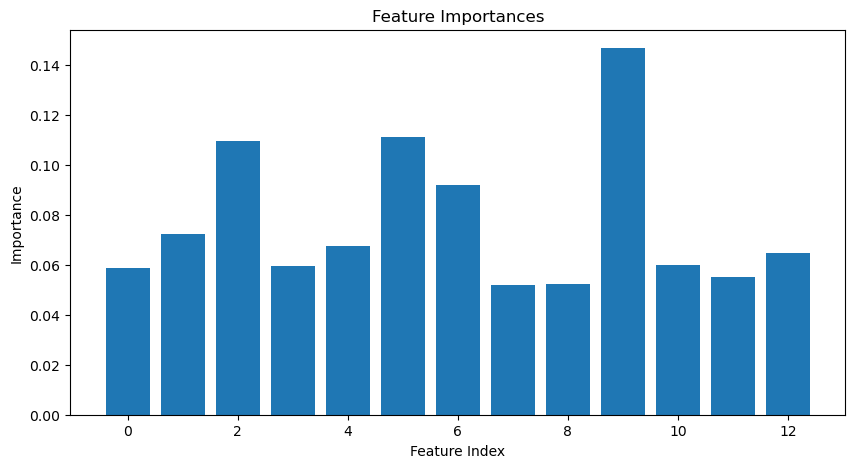

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


In [77]:
!pip install xgboost


##  Training an XGBoost Regressor

We use XGBoost, a powerful ensemble learning algorithm, to improve prediction accuracy.
It often performs well in regression tasks like this one.


In [ ]:
###  Training and Evaluating an XGBoost Regressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost model
xgb = XGBRegressor(
    n_estimators=100,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage
    random_state=42         # For reproducibility
)

#  Train the model on the training set
xgb.fit(X_train_split, y_train_split)

#  Predict on the validation set
xgb_pred = xgb.predict(X_val)

#  Evaluate the model
print(" XGBoost MSE:", mean_squared_error(y_val, xgb_pred))
print(" XGBoost R² Score:", r2_score(y_val, xgb_pred))


🚀 XGBoost MSE: 1.3720019088259512
🚀 XGBoost R² Score: -0.006494755249859319


##  Extracting Features from Test Audio Files

We extract MFCC features from each `.wav` file in the test folder using the same process as training.
These features will be passed to the final trained model for prediction.


In [ ]:
###  Extracting MFCC Features from Test Audio Files

import os
import librosa
import numpy as np

#  Path to the folder containing test audio files
test_path = r"C:\Users\simra\GrammarScoringEngine\audios_test"  

# Lists to store extracted features and corresponding filenames
test_features = []
test_filenames = []

# Loop through each audio file in the test directory
for file in os.listdir(test_path):
    if file.endswith(".wav"):
        file_path = os.path.join(test_path, file)

        # 🎧 Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        #  Extract MFCC features (same as training)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Append results
        test_features.append(mfccs_mean)
        test_filenames.append(file)

# Convert the list of feature vectors to a NumPy array
X_test_features = np.array(test_features)

#  Print summary
print(" Total test files processed:", len(test_filenames))
print(" Shape of X_test_features:", X_test_features.shape)


✅ Total test files processed: 195
📐 Shape of X_test_features: (195, 13)


In [96]:
# Predict using trained XGBoost model
y_test_pred = xgb.predict(X_test_features)


##  Generating Submission File

We use the trained model to predict grammar scores for test audio files.
The predictions are saved into a CSV file in the required submission format (`filename`, `label`).


In [ ]:
###Creating the Submission File

import pandas as pd

#Create a DataFrame with required columns: 'filename' and 'label'
submission = pd.DataFrame({
    'filename': test_filenames,   # filenames from test audio
    'label': y_test_pred          # predicted grammar scores from your model
})

#Save the submission file as a CSV (no index column)
submission.to_csv("submission.csv", index=False)

print(" Submission file saved as: submission.csv")


📄 Submission file saved as: submission.csv


In [102]:
import joblib
joblib.dump(xgb, 'final_grammar_model.pkl')
print("Model saved as: final_grammar_model.pkl")


Model saved as: final_grammar_model.pkl
